In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("CMX_ENAE_info.csv")

In [3]:
df.head()

,city,customer_id,submit_date,order_id,cat,gmv_usd,cant,Adjust_CLTV
0,CMX,28734703,2022-01-10,6491147,Abarrotes,3.66412,5.0,480.380128
1,CMX,28734703,2022-01-17,6849171,Lácteos & Huevos,17.00152,1.0,480.380128
2,CMX,28734703,2022-02-07,7431850,Abarrotes,43.01374,1.0,480.380128
3,CMX,28734703,2022-04-25,9906793,"Carne, Pollo & Pescados",5.80966,2.0,480.380128
4,CMX,28734703,2022-05-30,11087228,Desechables,22.68702,3.0,480.380128


In [4]:
df = df.sort_values(by='submit_date').reset_index(drop=True)

In [5]:
df = df.loc[~df.customer_id.isin([241784624,217375598])]

In [6]:
# Convert the 'submit_date' column to a datetime format
df['submit_date'] = pd.to_datetime(df['submit_date'])

# Calculate Recency
max_date = df['submit_date'].max()
df_r = df.groupby('customer_id').agg({'submit_date': lambda x: (max_date - x.max()).days}).reset_index()
df_r.columns = ['customer_id', 'R']

# Calculate Frequency
df_f = df.groupby('customer_id').agg({'order_id': 'count'}).reset_index()
df_f.columns = ['customer_id', 'F']

# Calculate Monetary
df_m = df.groupby('customer_id').agg({'gmv_usd': 'sum'}).reset_index()
df_m.columns = ['customer_id', 'M']

In [7]:
# Calculate the percentile values for R, F, and M
r_percentiles = np.percentile(df_r['R'], [20, 40, 60, 80])
f_percentiles = np.percentile(df_f['F'], [20, 40, 60, 80])
m_percentiles = np.percentile(df_m['M'], [20, 40, 60, 80])
#c_percentiles = np.percentile(df_c['C'], [20, 40, 60, 80])

# Assign R scores
df_r['R_score'] = np.where(df_r['R'] <= r_percentiles[0], 5,
                    np.where(df_r['R'] <= r_percentiles[1], 4,
                    np.where(df_r['R'] <= r_percentiles[2], 3,
                    np.where(df_r['R'] <= r_percentiles[3], 2, 1))))

# Assign F scores
df_f['F_score'] = np.where(df_f['F'] <= f_percentiles[0], 1,
                    np.where(df_f['F'] <= f_percentiles[1], 2,
                    np.where(df_f['F'] <= f_percentiles[2], 3,
                    np.where(df_f['F'] <= f_percentiles[3], 4, 5))))

# Assign M scores
df_m['M_score'] = np.where(df_m['M'] <= m_percentiles[0], 1,
                    np.where(df_m['M'] <= m_percentiles[1], 2,
                    np.where(df_m['M'] <= m_percentiles[2], 3,
                    np.where(df_m['M'] <= m_percentiles[3], 4, 5))))

In [8]:
# Calculate the Result
df_rfm = pd.merge(df_r, df_f, on='customer_id', how='outer')
#df_rfm = pd.merge(df_rfm, df_c, on='customer_id', how='outer')
df_rfm = pd.merge(df_rfm, df_m, on='customer_id', how='outer')
df_rfm['RFM'] = df_rfm['R_score'] * df_rfm['F_score'] * df_rfm['M_score']

In [9]:
# Merge with the Adjust_CLTV column
df_rfm = pd.merge(df_rfm, df[['customer_id', 'Adjust_CLTV']].drop_duplicates(), on=['customer_id'])

In [10]:
df_rfm.loc[df_rfm.Adjust_CLTV == df_rfm.Adjust_CLTV.max()]

,customer_id,R,R_score,F,F_score,M,M_score,RFM,Adjust_CLTV
174,-268153,33,2,2208,5,23172.15621,5,50,4748.239104


In [11]:
# calculate average order value
df_rfm['AOV'] = df_rfm['M'] / df_rfm['F']

# last order date
last_order = df.groupby('customer_id')['submit_date'].max().reset_index()
last_order = last_order.rename(columns={'submit_date': 'last_order_date'})

# find date of first order for each customer
first_order = df.groupby('customer_id')['submit_date'].min().reset_index()
first_order = first_order.rename(columns={'submit_date': 'first_order_date'})
first_order['longevity'] = max_date - first_order['first_order_date']

#frequency
frq = df.groupby('customer_id')
time_between_purchases = frq['submit_date'].diff()
time_between_purchases_df = pd.DataFrame({'customer_id': df['customer_id'],
                                          'time_between_purchases': time_between_purchases})
time_between_purchases_df = time_between_purchases_df.loc[time_between_purchases_df.time_between_purchases != '0 days']
avg_time_between_purchases = time_between_purchases_df.groupby(['customer_id'])['time_between_purchases'].mean().reset_index()
# round timedelta to nearest day and convert to integer
avg_time_between_purchases['time_between_purchases'] = avg_time_between_purchases['time_between_purchases'].dt.floor('d').dt.days

#calculate the number of different categories
dif_cats = df.groupby('customer_id').cat.nunique().reset_index()
dif_cats = dif_cats.rename(columns={'cat': 'numb_cats'})

In [12]:
df_rfm = pd.merge(df_rfm, first_order[['customer_id','longevity']], on='customer_id', how='left')
df_rfm = pd.merge(df_rfm, avg_time_between_purchases, on='customer_id', how='left')
df_rfm = pd.merge(df_rfm, dif_cats, on='customer_id', how='left')
df_rfm = pd.merge(df_rfm, last_order, on='customer_id', how='left')

df_rfm.time_between_purchases = df_rfm.time_between_purchases.fillna(0)

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

# Select the features for clustering
features = ["R_score", "F_score", "M_score", "time_between_purchases", "numb_cats"] #REGULARIDAD // VINCULACION

# Preprocess the data by scaling it
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_rfm[features])

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Apply Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(scaled_data)

In [14]:
df_rfm['k_means'] = kmeans_labels + 1
df_rfm['hierarchical'] = hierarchical_labels + 1

In [15]:
df_rfm.head()

,customer_id,R,R_score,F,F_score,M,M_score,RFM,Adjust_CLTV,AOV,longevity,time_between_purchases,numb_cats,last_order_date,k_means,hierarchical
0,-269919,11,4,1641,5,7273.29739,5,100,1104.693302,4.432235,354 days,2.0,7,2022-12-20,3,5
1,-269912,39,2,5,1,24.98063,1,2,0.000000,4.996126,306 days,267.0,3,2022-11-22,4,3
2,-269908,12,3,241,5,1894.05711,4,60,125.957743,7.859158,363 days,6.0,7,2022-12-19,3,2
3,-269896,16,3,54,3,2304.60231,5,45,164.169216,42.677821,355 days,8.0,6,2022-12-15,5,4
4,-269885,10,4,393,5,1327.08312,4,80,219.589349,3.376802,362 days,8.0,7,2022-12-21,3,5


In [16]:
df_rfm.k_means.value_counts()

3    6546
5    5752
2    5034
1    4744
4     377
Name: k_means, dtype: int64

In [17]:
df_rfm.hierarchical.value_counts()

1    6998
2    5574
4    5419
5    4131
3     331
Name: hierarchical, dtype: int64

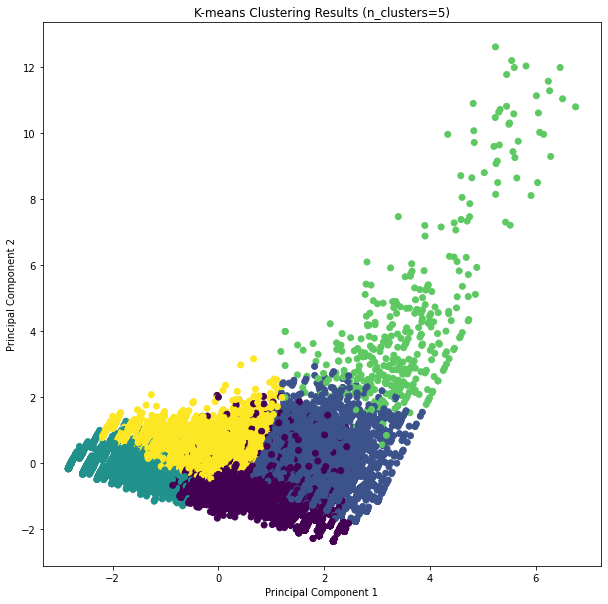

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.figure(figsize=(10,10))
# Reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Plot the clusters
plt.scatter(pca_data[:,0], pca_data[:,1], c=df_rfm.iloc[:,14], cmap='viridis')
plt.title('K-means Clustering Results (n_clusters=5)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

<Figure size 720x432 with 0 Axes>

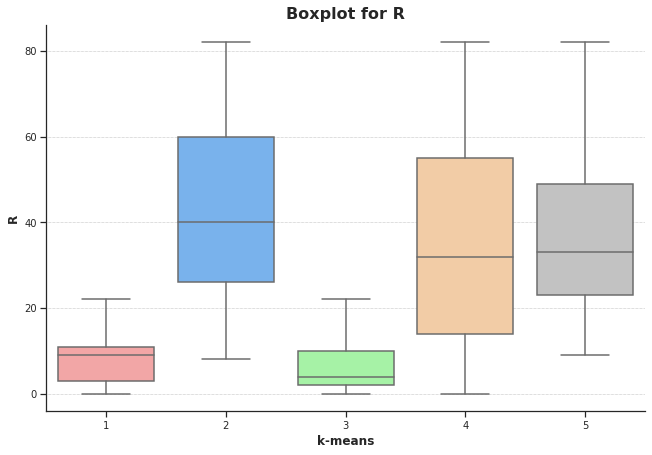

<Figure size 720x432 with 0 Axes>

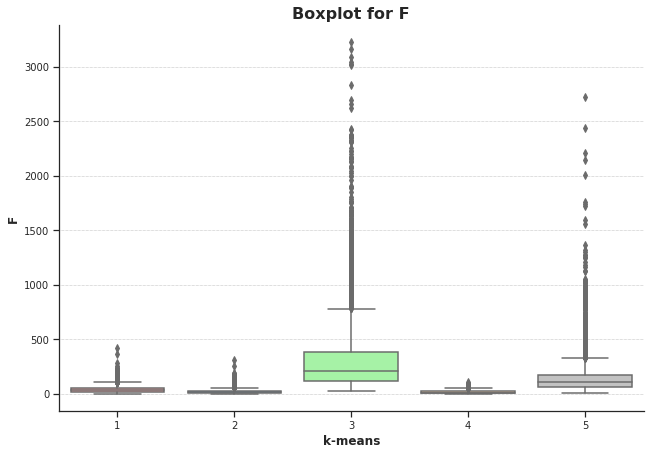

<Figure size 720x432 with 0 Axes>

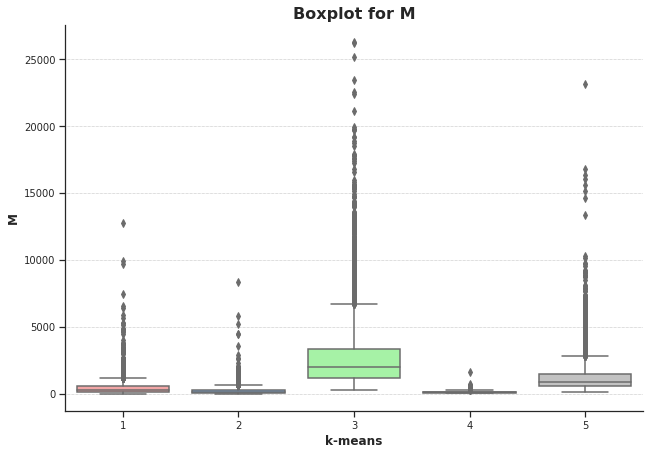

<Figure size 720x432 with 0 Axes>

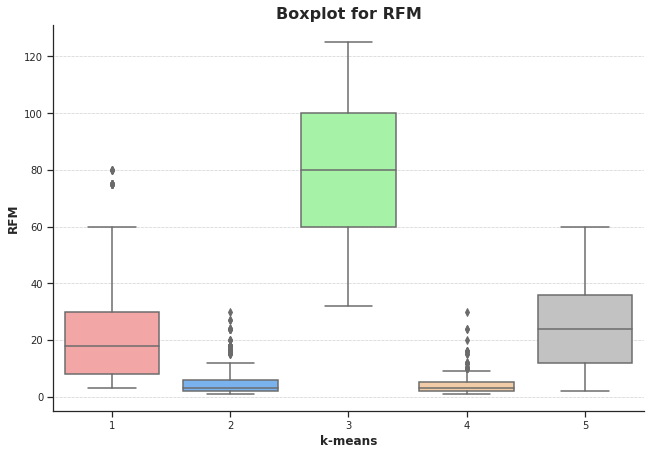

<Figure size 720x432 with 0 Axes>

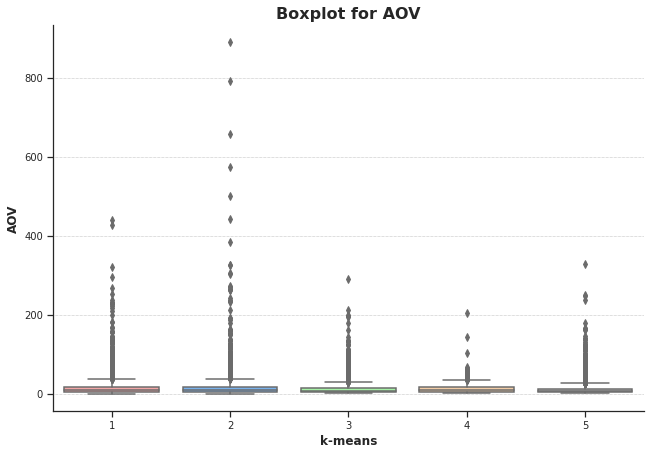

<Figure size 720x432 with 0 Axes>

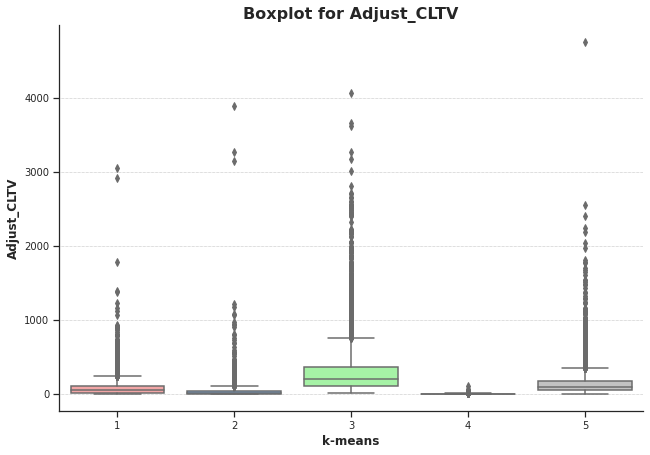

<Figure size 720x432 with 0 Axes>

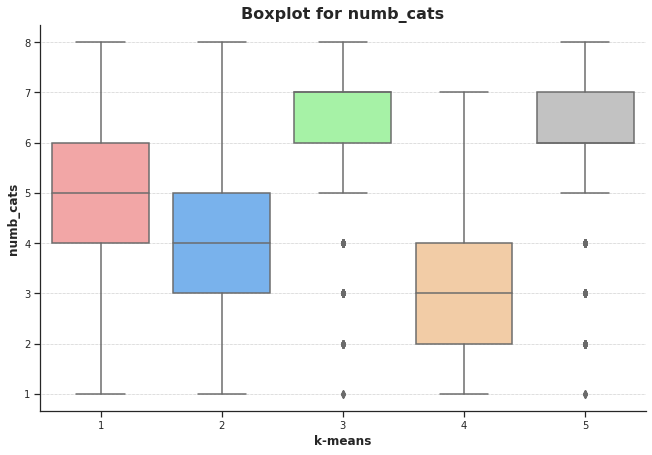

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
sns.set(style="whitegrid")

# Customize the color palette
palette = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#C2C2C2']

# Columns to create boxplots for
columns = ['R', 'F', 'M', 'RFM', 'AOV', 'Adjust_CLTV', 'numb_cats']

# Create a combined boxplot for each column
for column in columns:
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    
    # Set the plot style
    sns.set_style("ticks")
    
    # Create the boxplot
    sns.catplot(data=df_rfm, x='k_means', y=column, kind='box', height=6, aspect=1.5, palette=palette)
    
    # Customize the plot aesthetics
    plt.title(f"Boxplot for {column}", fontsize=16, fontweight='bold')
    plt.xlabel('k-means', fontsize=12, fontweight='bold')
    plt.ylabel(column, fontsize=12, fontweight='bold')
    
    # Customize tick labels
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Remove the top and right spines
    sns.despine()
    
    # Add a light grid to the plot
    plt.grid(axis='y', color='gray', linestyle=':', linewidth=0.5)
    
    # Show the plot
    plt.show()


In [20]:
df_rfm.head()

,customer_id,R,R_score,F,F_score,M,M_score,RFM,Adjust_CLTV,AOV,longevity,time_between_purchases,numb_cats,last_order_date,k_means,hierarchical
0,-269919,11,4,1641,5,7273.29739,5,100,1104.693302,4.432235,354 days,2.0,7,2022-12-20,3,5
1,-269912,39,2,5,1,24.98063,1,2,0.000000,4.996126,306 days,267.0,3,2022-11-22,4,3
2,-269908,12,3,241,5,1894.05711,4,60,125.957743,7.859158,363 days,6.0,7,2022-12-19,3,2
3,-269896,16,3,54,3,2304.60231,5,45,164.169216,42.677821,355 days,8.0,6,2022-12-15,5,4
4,-269885,10,4,393,5,1327.08312,4,80,219.589349,3.376802,362 days,8.0,7,2022-12-21,3,5


# Prediccion

In [21]:
df_rfm['longevity'] = df_rfm['longevity'].dt.days
dfp = df_rfm.copy()

In [22]:
from datetime import datetime, timedelta

# Calcular la fecha actual
fecha_actual = dfp.last_order_date.max()

# Calcular la fecha límite para considerar a un cliente como abandonado
fecha_limite = fecha_actual - timedelta(weeks=3)

# Crear la columna 'Abandono' basada en la condición de tiempo desde la última compra
dfp['Abandono'] = dfp['last_order_date'].apply(lambda x: 1 if x < fecha_limite else 0)

In [23]:
dfp.Abandono.value_counts()

0    13273
1     9180
Name: Abandono, dtype: int64

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [25]:
dfp.columns

Index(['customer_id', 'R', 'R_score', 'F', 'F_score', 'M', 'M_score', 'RFM',
       'Adjust_CLTV', 'AOV', 'longevity', 'time_between_purchases',
       'numb_cats', 'last_order_date', 'k_means', 'hierarchical', 'Abandono'],
      dtype='object')

In [26]:
# Splitting into features (X) and target variable (y)
selected_features = ['AOV', 'longevity','RFM', 'Adjust_CLTV', 'numb_cats','time_between_purchases'] #meter R F M
X = dfp[selected_features]
y = dfp['Abandono']

In [27]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# Crear un objeto StandardScaler
scaler = StandardScaler()

# Ajustar el scaler solo al conjunto de entrenamiento
X_train = scaler.fit_transform(X_train)

In [29]:
# Train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Ajustar el scaler solo al conjunto de prueba
X_test = scaler.transform(X_test)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.8692102137767221
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3956
           1       0.84      0.84      0.84      2780

    accuracy                           0.87      6736
   macro avg       0.87      0.87      0.87      6736
weighted avg       0.87      0.87      0.87      6736



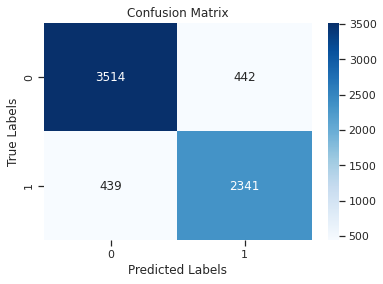

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have predicted values in 'y_pred' and true values in 'y_true'
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [31]:
dfp['predicted_abandono'] = logreg.predict(scaler.transform(dfp[selected_features]))

In [33]:
cluster_probabilities = dfp.groupby('k_means')['predicted_abandono'].mean()

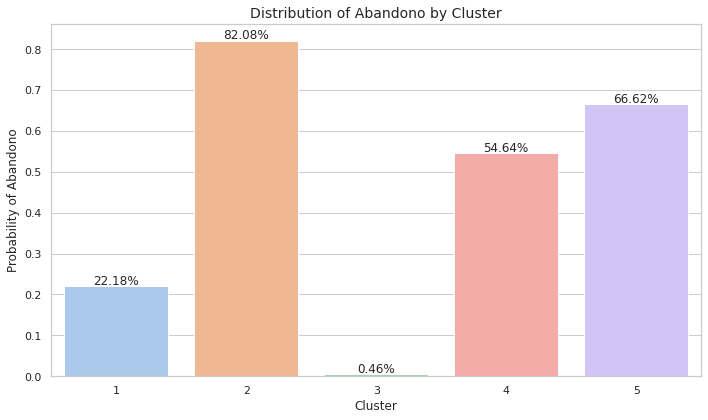

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plot
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
colors = sns.color_palette('pastel')
ax = sns.barplot(x=cluster_probabilities.index, y=cluster_probabilities, palette=colors)

# Customize the plot
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Probability of Abandono', fontsize=12)
plt.title('Distribution of Abandono by Cluster', fontsize=14)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2%'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

# Show the plot
plt.tight_layout()
plt.show()